**Note:** 
- For running this notebook, I recommend you to run one by one cell. Read all of those steps carefully!
- This experiment has been done until 10 epochs but due to computational issue, I only run the model until 5 epochs

For the dataset which would use is https://www.kaggle.com/datasets/maimunulkjisan/rice-leaf-datasettrain-test-and-valid

## Data Preparation

First I should prepare for libraries

In [1]:
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import ModelCheckpoint

2025-01-11 11:12:24.108460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 11:12:24.128411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736593944.148616     537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736593944.154775     537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 11:12:24.175088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

After that, I downloaded the dataset and extracted it into a folder

In [2]:
# These codes below are for extracting files from zip into folders
zip_file = "rice_leaf_datasets.zip"
extract_to = "rice_leaf_datasets"

try:
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted files to: {extract_to}")
except zipfile.BadZipFile:
    print("Error: File is not a valid ZIP archive or is corrupted.")

Extracted files to: rice_leaf_datasets


Let's open the image!

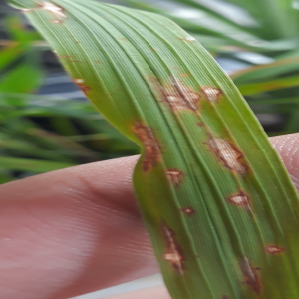

In [3]:
path = "./rice_leaf_datasets/train/Blast"
name = "BLAST1_008.jpg"
img_name = f"{path}/{name}"

img = load_img(img_name, target_size=(299,299))
img

Before jumping into EDA, I must save an array from this image by this code below...

In [4]:
img_array = np.array(img)
img_array

array([[[ 65,  72,  76],
        [ 66,  73,  76],
        [ 70,  76,  78],
        ...,
        [135, 172, 142],
        [131, 169, 141],
        [129, 167, 140]],

       [[ 65,  71,  75],
        [ 65,  73,  76],
        [ 68,  76,  78],
        ...,
        [148, 180, 159],
        [146, 178, 159],
        [144, 176, 158]],

       [[ 65,  73,  76],
        [ 66,  74,  76],
        [ 67,  75,  77],
        ...,
        [161, 191, 176],
        [161, 188, 177],
        [159, 184, 176]],

       ...,

       [[163, 118, 121],
        [162, 117, 120],
        [161, 116, 119],
        ...,
        [ 87, 105,  20],
        [ 88, 104,  23],
        [ 87, 102,  25]],

       [[162, 117, 122],
        [162, 117, 121],
        [163, 118, 121],
        ...,
        [ 88, 106,  20],
        [ 88, 106,  22],
        [ 89, 105,  24]],

       [[162, 117, 122],
        [162, 117, 121],
        [162, 117, 120],
        ...,
        [ 88, 107,  20],
        [ 90, 108,  22],
        [ 90, 107,  24]]

This array is 3D array so I wanted to wrap this array into 4D array later

## EDA 

Before I jump into the model, I must know about this dataset, so I analyzed it by... <br>

1. Counting amount of images in train, valid, and test folders with the plots

In [5]:
base_dir = "./rice_leaf_datasets/"
data_splits = ["train", "val", "test"]
class_distribution = {}

In [6]:
for split in data_splits:
    split_dir = os.path.join(base_dir, split)
    class_distribution[split] = {}

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)

        if os.path.isdir(class_dir):  # Check if it's a directory
            num_images = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_distribution[split][class_name] = num_images

# Print the distribution
print("Class Distribution Across Folders:")
for split, classes in class_distribution.items():
    print(f"{split}:")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count} images")

Class Distribution Across Folders:
train:
  Brownspot: 1280 images
  Bacterialblight: 1070 images
  Blast: 731 images
  Tungro: 328 images
val:
  Brownspot: 160 images
  Bacterialblight: 127 images
  Blast: 98 images
  Tungro: 53 images
test:
  Brownspot: 160 images
  Bacterialblight: 129 images
  Blast: 89 images
  Tungro: 43 images


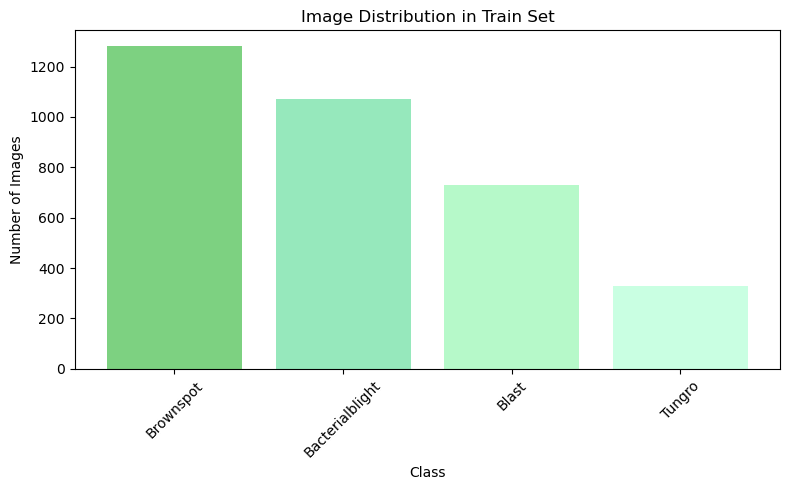

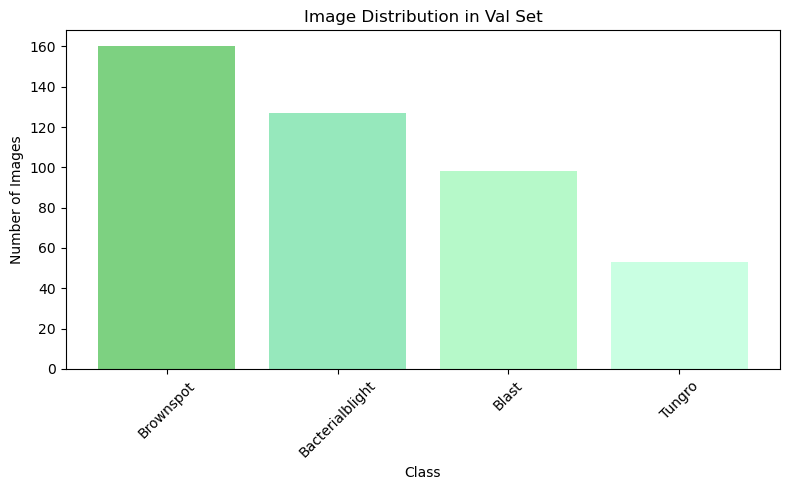

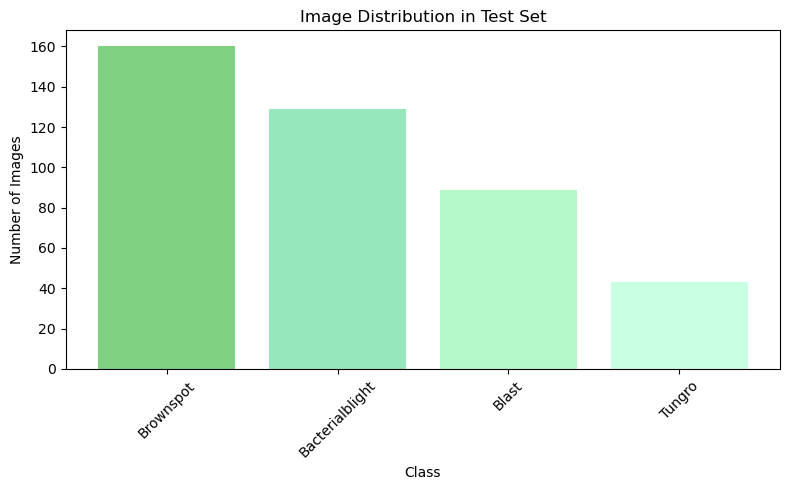

In [7]:
for split, classes in class_distribution.items():
    labels = list(classes.keys())
    values = list(classes.values())

    plt.subplots(figsize=(8, 5))
    plt.bar(labels, values, color=['#7DD181', '#96E8BC', '#B6F9C9', '#C9FFE2'])
    plt.title(f"Image Distribution in {split.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

2. Checking the distribution of image sizes:

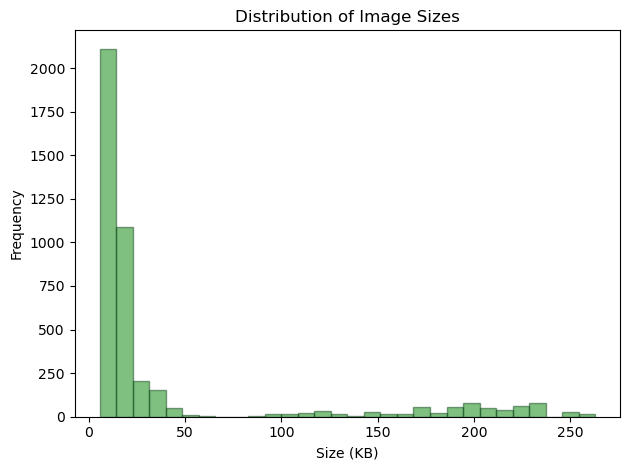

In [8]:
image_sizes = []

# This will go into train, valid, and test folders
for split in data_splits:
    split_dir = os.path.join(base_dir, split)
    # class_distribution[split] = {}

    # This code will check on train, valid, and test folders
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)

        # This will check on several folders from each other folders from train, valid, and test
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                if image_file.endswith((".png", ".jpg", ".jpeg")):
                    file_path = os.path.join(class_dir, image_file)
                    image_sizes.append(os.path.getsize(file_path))

# Convert sizes into KB for easier interpretation
image_sizes_kb = [size / 1024 for size in image_sizes]

plt.figure()
plt.hist(image_sizes_kb, bins=30, color="green", alpha=0.5, edgecolor="#10451D")
plt.title("Distribution of Image Sizes")
plt.xlabel("Size (KB)")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()

In [9]:
print(f"Average size: {np.average(image_sizes_kb):.2f} KB")
print(f"Min size: {min(image_sizes_kb):.2f} KB")
print(f"Max size: {max(image_sizes_kb):.2f} KB")

Average size: 41.18 KB
Min size: 5.52 KB
Max size: 262.97 KB


3. Checking data if there are corrupted images:

In [10]:
def check_image(base_dir):
    corrupted_img = []

    for dirpath, _, filenames in os.walk(base_dir):
        print(f"Scanning directory: {dirpath}")

        for img_file in filenames:
            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(dirpath, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception as e:
                    corrupted_img.append(img_path)
                    print(f"{img_path} is Error: {e}")

    return corrupted_img

corrupted_img = check_image(base_dir)
if corrupted_img:
    print(f"Caution! Found {count(corrupted_img)} corrupted images. Please think about the next action from those files!")
else:
    print("No images are corrupted! You can go into the next step")

Scanning directory: ./rice_leaf_datasets/
Scanning directory: ./rice_leaf_datasets/test
Scanning directory: ./rice_leaf_datasets/test/Brownspot
Scanning directory: ./rice_leaf_datasets/test/Bacterialblight
Scanning directory: ./rice_leaf_datasets/test/Blast
Scanning directory: ./rice_leaf_datasets/test/Tungro
Scanning directory: ./rice_leaf_datasets/train
Scanning directory: ./rice_leaf_datasets/train/Brownspot
Scanning directory: ./rice_leaf_datasets/train/Bacterialblight
Scanning directory: ./rice_leaf_datasets/train/Blast
Scanning directory: ./rice_leaf_datasets/train/Tungro
Scanning directory: ./rice_leaf_datasets/val
Scanning directory: ./rice_leaf_datasets/val/Brownspot
Scanning directory: ./rice_leaf_datasets/val/Bacterialblight
Scanning directory: ./rice_leaf_datasets/val/Blast
Scanning directory: ./rice_leaf_datasets/val/Tungro
No images are corrupted! You can go into the next step


## Model

Due to computational issue in Saturn Cloud and local computer, I only used these pre-trained model from Keras, including... 
1. Xception
2. MobileNet
3. EfficientNetB2

### Xception

I wanted to check prediction of this image with this raw Xception model 

#### Pre-trained CNN

First, I assign the weights and input shape for configuration in this model into the image

In [11]:
xception_model = Xception(weights="imagenet", input_shape=(299,299,3))

I0000 00:00:1736593955.068462     537 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


then, we wrapped from previous image array into 4D array

In [12]:
img = np.array([img_array])

In [13]:
img.shape

(1, 299, 299, 3)

after that, I preprocessed the image and predicted it

In [14]:
img = preprocess_input(img)

In [15]:
pred = xception_model.predict(img)

I0000 00:00:1736593958.586330     600 service.cc:148] XLA service 0x7ff3a4001d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736593958.586369     600 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-11 11:12:38.624716: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736593958.973582     600 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-11 11:12:40.140944: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1736593960.983984     600 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


If we decide prediction from that image

In [16]:
decode_predictions(pred)

[[('n13133613', 'ear', np.float32(0.24154234)),
  ('n02236044', 'mantis', np.float32(0.04472313)),
  ('n12057211', "yellow_lady's_slipper", np.float32(0.043412305)),
  ('n01644900', 'tailed_frog', np.float32(0.042237744)),
  ('n01644373', 'tree_frog', np.float32(0.040472027))]]

turns out that the prediction result is wrong so we need to craft different model as a base model with certain classes which we need

#### Build and train CNN base model

In [17]:
train_gen_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
train_dataset = train_gen_xception.flow_from_directory("./rice_leaf_datasets/train", target_size=(150,150), batch_size=32)

Found 4745 images belonging to 4 classes.


In [18]:
train_dataset.class_indices

{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Tungro': 3}

In [19]:
X, y = next(train_dataset)

In [20]:
valid_gen_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
valid_dataset = valid_gen_xception.flow_from_directory("./rice_leaf_datasets/val", target_size=(150,150), batch_size=32, shuffle=False)

Found 592 images belonging to 4 classes.


In [21]:
def make_xception_model(learning_rate=0.01, size_inner=0, droprate=0.0):
    base_model = Xception(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False) 
    vectors = keras.layers.GlobalAveragePooling2D()(base) 

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    dropout = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(4)(dropout) 
    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [22]:
xception_model = make_xception_model(learning_rate=0.01, size_inner=0, droprate=0.0)

In [23]:
history = xception_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

Epoch 1/5


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.2655 - loss: 1.3842 - val_accuracy: 0.2703 - val_loss: 1.3833
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2692 - loss: 1.3836 - val_accuracy: 0.2703 - val_loss: 1.3835
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2655 - loss: 1.3843 - val_accuracy: 0.2703 - val_loss: 1.3833
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2698 - loss: 1.3841 - val_accuracy: 0.2669 - val_loss: 1.3830
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2755 - loss: 1.3813 - val_accuracy: 0.2669 - val_loss: 1.3837


#### Hyperparameter tuning and checkpoint

Because those results above are still have low accurate in validation so I had to tune different parameters. To consider for choosing results from those parameter I must look from validation accuracy and validation loss, so with the higher result in validation accuracy and lower result in validation loss, the better the model is. <br>

1. Tuning learning rate

In [24]:
results = {}

for learning_rate in [0.0001, 0.001, 0.01]:
    print(learning_rate)

    xception_model = make_xception_model(learning_rate=learning_rate, size_inner=0, droprate=0.0)
    history = xception_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[learning_rate] = history.history

    print()

0.0001
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.2590 - loss: 1.3862 - val_accuracy: 0.2703 - val_loss: 1.3860
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2605 - loss: 1.3859 - val_accuracy: 0.2703 - val_loss: 1.3858
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2773 - loss: 1.3857 - val_accuracy: 0.2703 - val_loss: 1.3855
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2715 - loss: 1.3855 - val_accuracy: 0.2703 - val_loss: 1.3853
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2679 - loss: 1.3855 - val_accuracy: 0.2703 - val_loss: 1.3851

0.001
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2546 - loss: 1.3858 - val_accuracy: 0.2703 - val_loss: 1.3843
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2612 - loss: 1.3837 - val_accuracy: 0.2703 - val_loss: 1.3835
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2704 - loss: 1.3833 - 

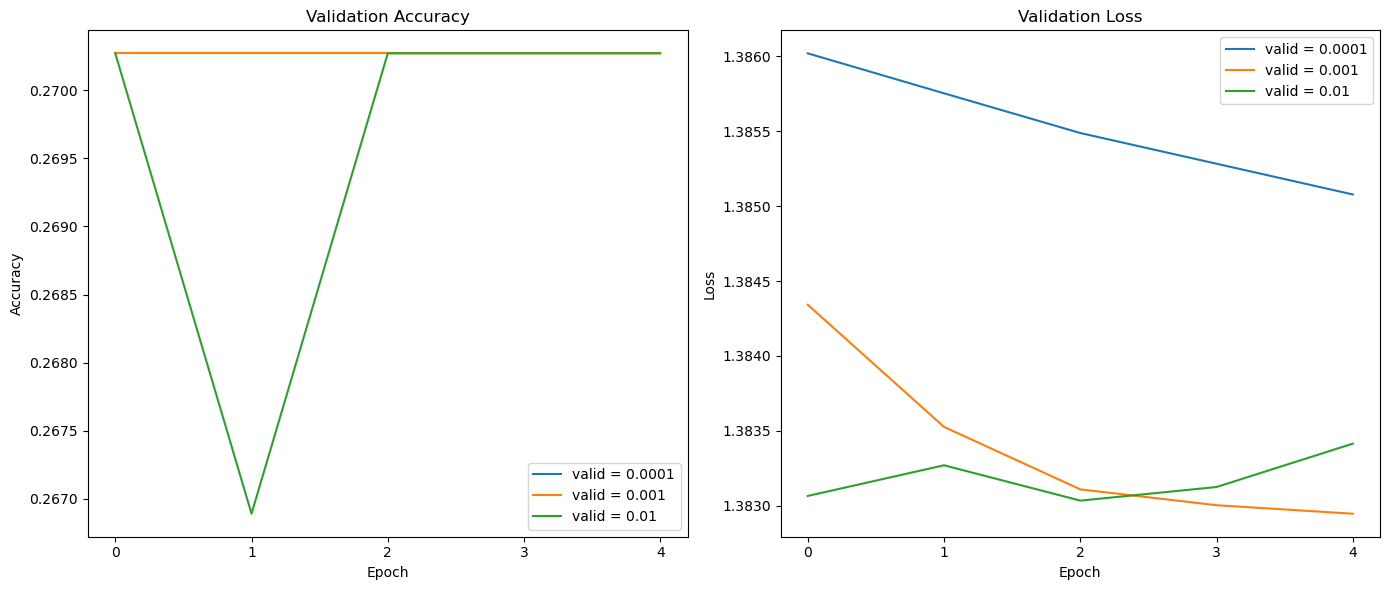

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for lr, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % lr))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for lr, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % lr))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

2. Tuning inner size

In [26]:
learning_rate=0.001
results = {}

for size in [10, 100, 1000]:
    print(size)

    xception_model = make_xception_model(learning_rate=learning_rate, size_inner=size, droprate=0.0)
    history = xception_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[size] = history.history
    
    print()

10
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.6432 - loss: 0.8411 - val_accuracy: 0.8834 - val_loss: 0.3462
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9391 - loss: 0.2428 - val_accuracy: 0.9628 - val_loss: 0.1710
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9731 - loss: 0.1241 - val_accuracy: 0.9780 - val_loss: 0.1195
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9898 - loss: 0.0788 - val_accuracy: 0.9932 - val_loss: 0.0748
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9958 - loss: 0.0496 - val_accuracy: 0.9899 - val_loss: 0.0619

100
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.8036 - loss: 0.5131 - val_accuracy: 0.9780 - val_loss: 0.1043
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9799 - loss: 0.0803 - val_accuracy: 0.9932 - val_loss: 0.0422
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9969 - loss: 0.0249 - val_a

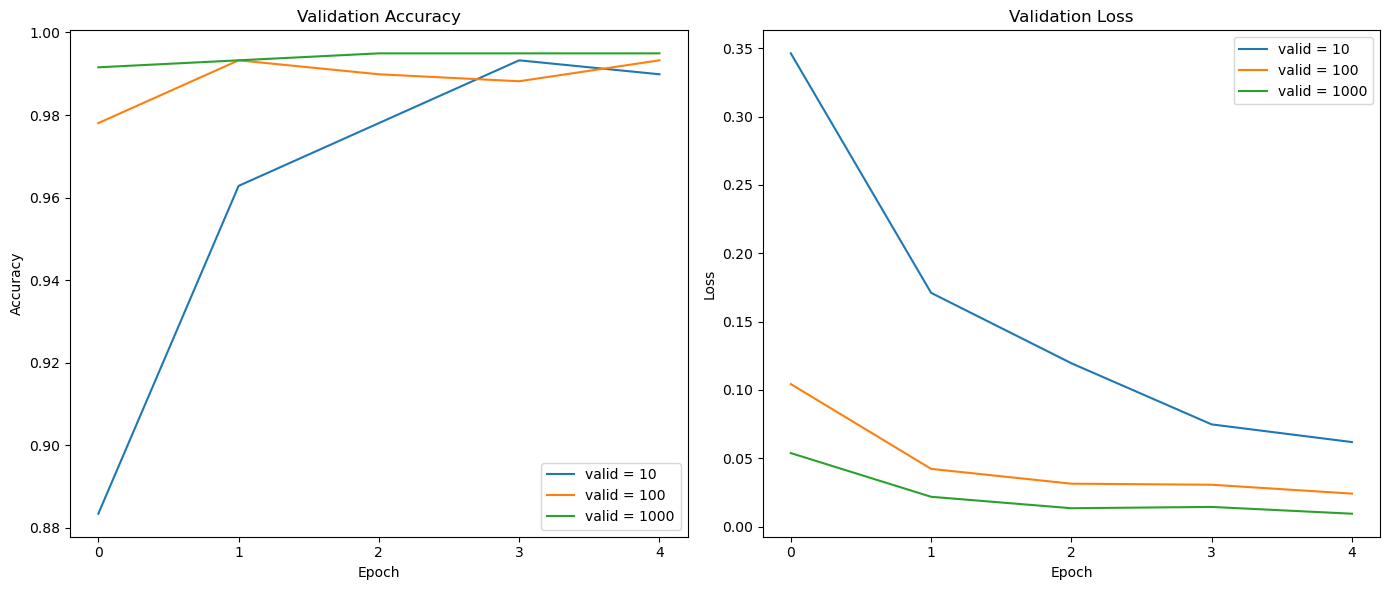

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for size, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % size))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for size, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % size))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

3. Tuning droprate

In [28]:
learning_rate=0.001
size=1000
results = {}

for droprate in [0.0, 0.2, 0.5]:
    print(droprate)

    xception_model = make_xception_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = xception_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[droprate] = history.history
    
    print()

0.0
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.8240 - loss: 0.4617 - val_accuracy: 0.9764 - val_loss: 0.0898
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9833 - loss: 0.0531 - val_accuracy: 0.9949 - val_loss: 0.0166
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9995 - loss: 0.0073 - val_accuracy: 0.9966 - val_loss: 0.0085
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9949 - val_loss: 0.0103
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9966 - val_loss: 0.0096

0.2
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8022 - loss: 0.5444 - val_accuracy: 0.9747 - val_loss: 0.0876
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9843 - loss: 0.0576 - val_accuracy: 0.9966 - val_loss: 0.0257
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9954 - loss: 0.0187 - val_a

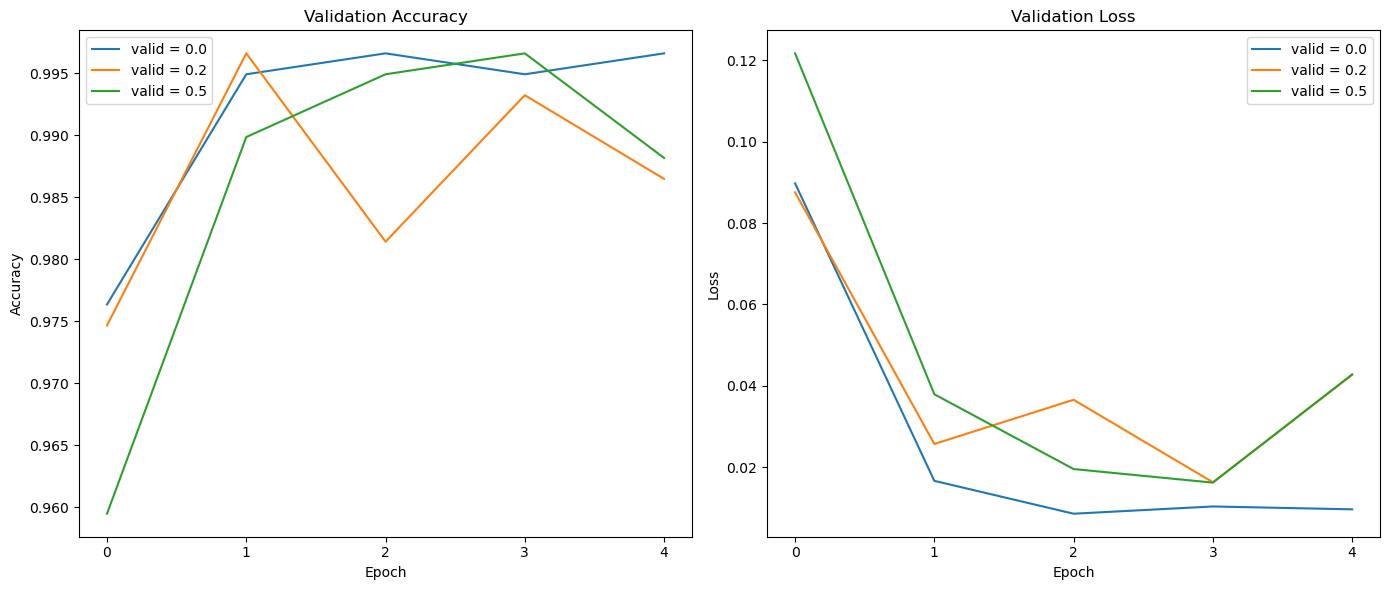

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for droprate, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % droprate))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for droprate, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % droprate))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

In [30]:
xception_checkpoint = ModelCheckpoint("xception_{epoch:02d}_{val_accuracy:.3f}.keras", save_best_only=True, monitor="val_accuracy", mode="max")

In [31]:
learning_rate = 0.001
size=1000
droprate=0.0

xception_model = make_xception_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

history = xception_model.fit(train_dataset, epochs=5, validation_data=valid_dataset, callbacks=[xception_checkpoint])

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8336 - loss: 0.4441 - val_accuracy: 0.9831 - val_loss: 0.0877
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9903 - loss: 0.0413 - val_accuracy: 0.9730 - val_loss: 0.0769
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9922 - loss: 0.0303 - val_accuracy: 0.9916 - val_loss: 0.0312
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9984 - loss: 0.0105 - val_accuracy: 0.9983 - val_loss: 0.0068
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9949 - val_loss: 0.0083


### MobileNet

We can do same things for MobileNet except checking the prediction by using raw MobileNet

#### Build and train CNN base model

In [32]:
train_gen_mobilenet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
train_dataset = train_gen_mobilenet.flow_from_directory("./rice_leaf_datasets/train", target_size=(200,200), batch_size=32)

Found 4745 images belonging to 4 classes.


In [33]:
X, y = next(train_dataset)

In [34]:
valid_gen_mobilenet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
valid_dataset = valid_gen_mobilenet.flow_from_directory("./rice_leaf_datasets/val", target_size=(200,200), batch_size=32, shuffle=False)

Found 592 images belonging to 4 classes.


In [35]:
def make_mobilenet_model(learning_rate=0.01, size_inner=0, droprate=0.0):
    base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
    base_model.trainable = False

    #########################################
    
    inputs = keras.Input(shape=(200,200,3))
    base = base_model(inputs, training=False) 
    vectors = keras.layers.GlobalAveragePooling2D()(base) 

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    dropout = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(4)(dropout) 
    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [36]:
mobilenet_model = make_mobilenet_model(learning_rate=0.01, size_inner=0, droprate=0.0)

/tmp/ipykernel_537/4294050529.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


In [37]:
history = mobilenet_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2603 - loss: 1.3851 - val_accuracy: 0.2669 - val_loss: 1.3830
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.2590 - loss: 1.3828 - val_accuracy: 0.2703 - val_loss: 1.3831
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2729 - loss: 1.3815 - val_accuracy: 0.2703 - val_loss: 1.3832
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.2723 - loss: 1.3844 - val_accuracy: 0.2669 - val_loss: 1.3831
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2677 - loss: 1.3843 - val_accuracy: 0.2669 - val_loss: 1.3832


#### Hyperparameter tuning and checkpoint

1. Tuning learning_rate

In [38]:
results = {}

for learning_rate in [0.0001, 0.001, 0.01]:
    print(learning_rate)

    mobilenet_model = make_mobilenet_model(learning_rate=learning_rate, size_inner=0, droprate=0.0)
    history = mobilenet_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[learning_rate] = history.history

    print()

0.0001


/tmp/ipykernel_537/4294050529.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.2629 - loss: 1.3862 - val_accuracy: 0.2703 - val_loss: 1.3860
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2584 - loss: 1.3860 - val_accuracy: 0.2703 - val_loss: 1.3858
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2641 - loss: 1.3858 - val_accuracy: 0.2703 - val_loss: 1.3855
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2668 - loss: 1.3853 - val_accuracy: 0.2703 - val_loss: 1.3853
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.2732 - loss: 1.3849 - val_accuracy: 0.2703 - val_loss: 1.3851

0.001
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2427 - loss: 1.3858 - val_accuracy: 0.2669 - val_loss: 1.3843
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2635 - loss: 1.3835 - val_accuracy: 0.2703 - val_loss: 1.3835
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2453 - loss: 1.3835 - val_ac

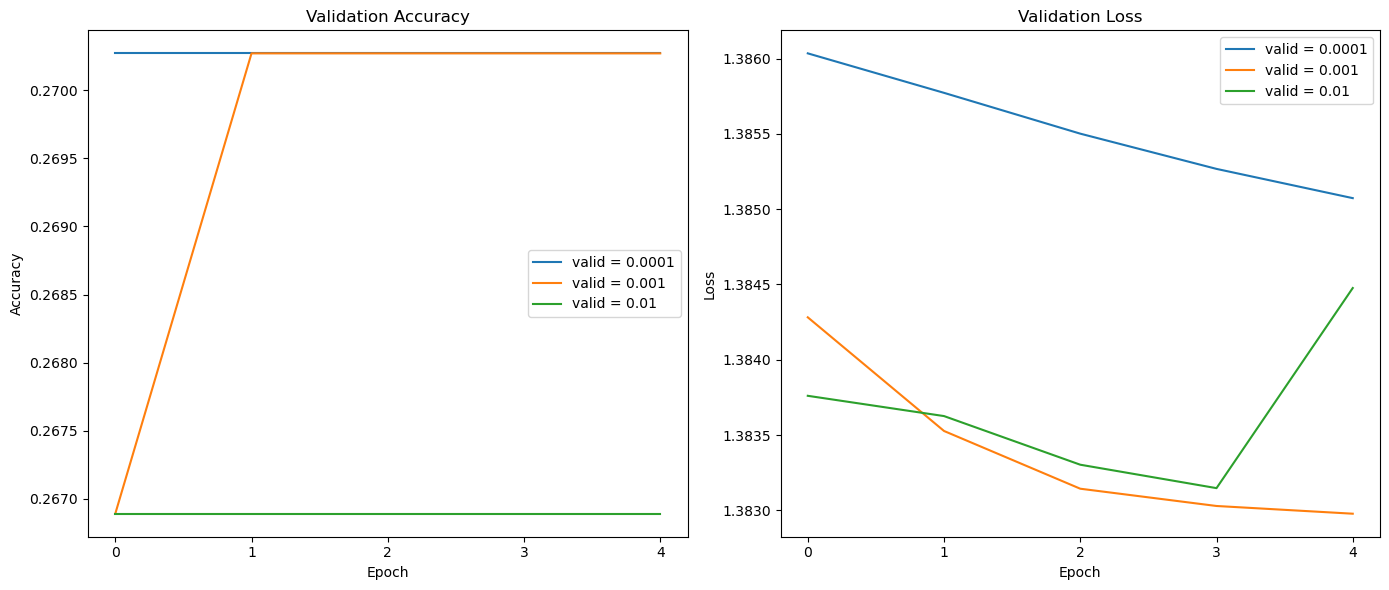

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for lr, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % lr))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for lr, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % lr))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

2. Tuning inner size

In [40]:
learning_rate=0.001
results = {}

for size in [10, 100, 1000]:
    print(size)

    mobilenet_model = make_mobilenet_model(learning_rate=learning_rate, size_inner=size, droprate=0.0)
    history = mobilenet_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[size] = history.history
    
    print()

10


/tmp/ipykernel_537/4294050529.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.6598 - loss: 0.8032 - val_accuracy: 0.9493 - val_loss: 0.2138
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9523 - loss: 0.1686 - val_accuracy: 0.9916 - val_loss: 0.0957
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9894 - loss: 0.0692 - val_accuracy: 0.9966 - val_loss: 0.0430
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9965 - loss: 0.0342 - val_accuracy: 0.9983 - val_loss: 0.0238
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9998 - loss: 0.0170 - val_accuracy: 0.9983 - val_loss: 0.0159

100
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8047 - loss: 0.4899 - val_accuracy: 0.9966 - val_loss: 0.0474
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9964 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accu

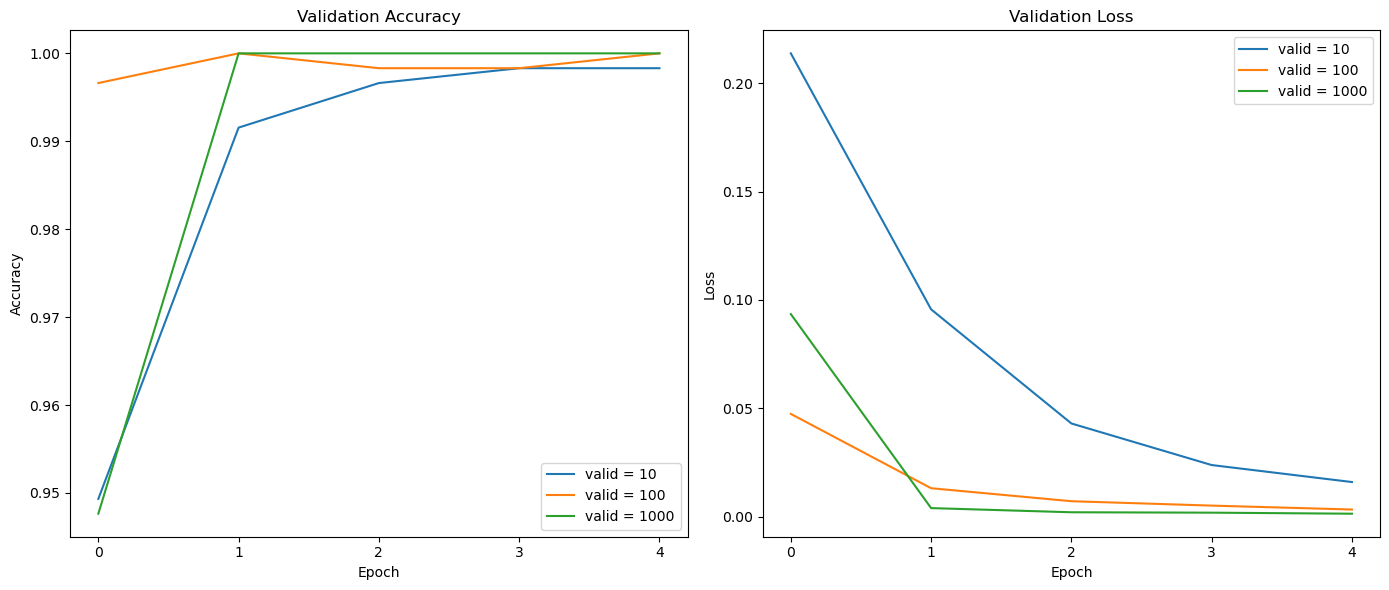

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for size, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % size))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for size, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % size))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

3. Tuning droprate

In [42]:
learning_rate=0.001
size=1000
results = {}

for droprate in [0.0, 0.2, 0.5]:
    print(droprate)

    mobilenet_model = make_mobilenet_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = mobilenet_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[droprate] = history.history
    
    print()

0.0


/tmp/ipykernel_537/4294050529.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.8479 - loss: 0.5052 - val_accuracy: 0.9966 - val_loss: 0.0131
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9992 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 1.0000 - loss: 9.0277e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 1.0000 - loss: 5.4660e-04 - val_accuracy: 1.0000 - val_loss: 9.9410e-04

0.2
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8579 - loss: 0.4161 - val_accuracy: 0.9983 - val_loss: 0.0162
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9949 - loss: 0.0148 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 1.0000 - loss: 0.002

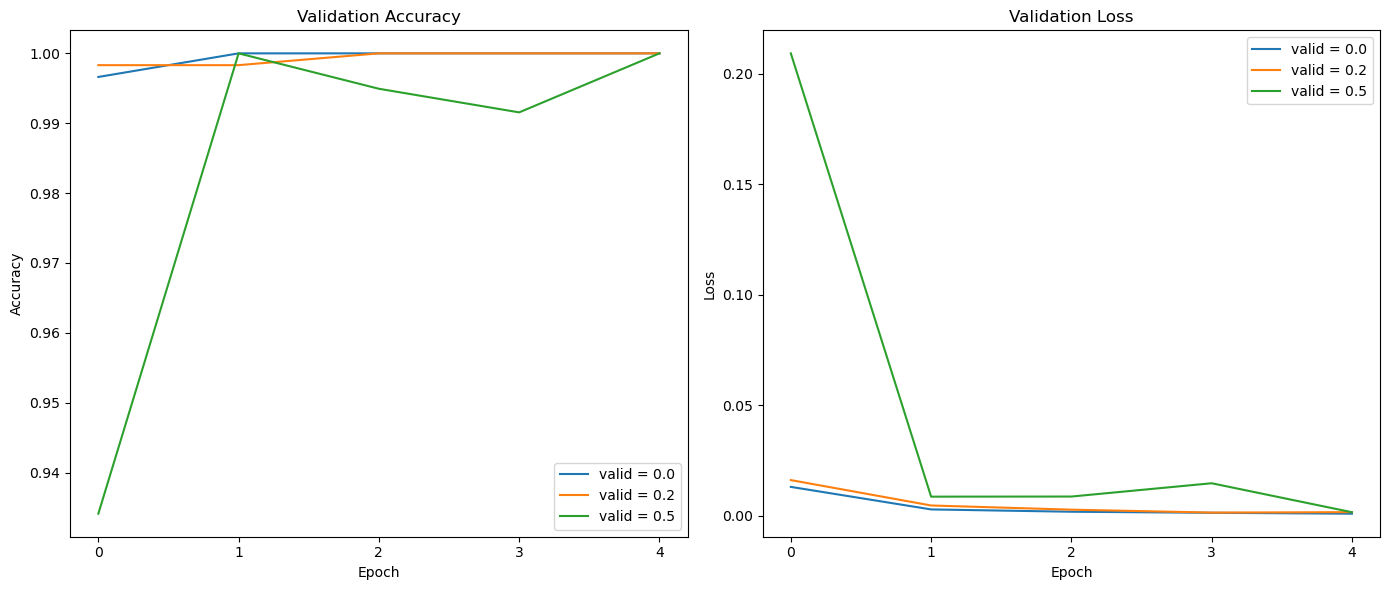

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for droprate, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % droprate))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for droprate, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % droprate))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

In [44]:
mobilenet_checkpoint = ModelCheckpoint("mobilenet_{epoch:02d}_{val_accuracy:.3f}.keras", save_best_only=True, monitor="val_accuracy", mode="max")

In [45]:
learning_rate = 0.001
size=1000
droprate=0.0

mobilenet_model = make_mobilenet_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

history = mobilenet_model.fit(train_dataset, epochs=5, validation_data=valid_dataset, callbacks=[mobilenet_checkpoint])

/tmp/ipykernel_537/4294050529.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8291 - loss: 0.5330 - val_accuracy: 0.9983 - val_loss: 0.0154
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9991 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 1.0000 - loss: 7.6885e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 1.0000 - loss: 5.5667e-04 - val_accuracy: 1.0000 - val_loss: 0.0012


### EfficientNetB2

Also do the same things for EfficientNetB2

#### Build and train CNN base model

In [46]:
train_gen_efficientnetb2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_dataset = train_gen_efficientnetb2.flow_from_directory("./rice_leaf_datasets/train", target_size=(260,260), batch_size=32)

Found 4745 images belonging to 4 classes.


In [47]:
X, y = next(train_dataset)

In [48]:
valid_gen_efficientnetb2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
valid_dataset = valid_gen_efficientnetb2.flow_from_directory("./rice_leaf_datasets/val", target_size=(260,260), batch_size=32, shuffle=False)

Found 592 images belonging to 4 classes.


In [49]:
def make_efficientnetb2_model(learning_rate=0.01, size_inner=0, droprate=0.0):
    base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(260, 260, 3))
    base_model.trainable = False

    #########################################
    
    inputs = keras.Input(shape=(260,260,3))
    base = base_model(inputs, training=False) 
    vectors = keras.layers.GlobalAveragePooling2D()(base) 

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    dropout = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(4)(dropout) 
    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [50]:
efficientnetb2_model = make_efficientnetb2_model(learning_rate=0.01, size_inner=0, droprate=0.0)

In [51]:
history = efficientnetb2_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.2626 - loss: 1.3849 - val_accuracy: 0.2703 - val_loss: 1.3833
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.2629 - loss: 1.3830 - val_accuracy: 0.2703 - val_loss: 1.3836
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2686 - loss: 1.3837 - val_accuracy: 0.2703 - val_loss: 1.3830
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.2652 - loss: 1.3831 - val_accuracy: 0.2703 - val_loss: 1.3841
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2703 - loss: 1.3824 - val_accuracy: 0.2669 - val_loss: 1.3837


#### Hyperparameter tuning and checkpoint

1. Tuning learning rate

In [52]:
results = {}

for learning_rate in [0.0001, 0.001, 0.01]:
    print(learning_rate)

    efficientnetb2_model = make_efficientnetb2_model(learning_rate=learning_rate, size_inner=0, droprate=0.0)
    history = efficientnetb2_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[learning_rate] = history.history

    print()

0.0001
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.2580 - loss: 1.3863 - val_accuracy: 0.2703 - val_loss: 1.3860
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.2600 - loss: 1.3861 - val_accuracy: 0.2669 - val_loss: 1.3858
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2625 - loss: 1.3857 - val_accuracy: 0.2703 - val_loss: 1.3855
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.2585 - loss: 1.3852 - val_accuracy: 0.2703 - val_loss: 1.3853
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2707 - loss: 1.3850 - val_accuracy: 0.2669 - val_loss: 1.3851

0.001
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.2725 - loss: 1.3857 - val_accuracy: 0.2669 - val_loss: 1.3842
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.2588 - loss: 1.3843 - val_accuracy: 0.2703 - val_loss: 1.3835
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2555 - loss: 1

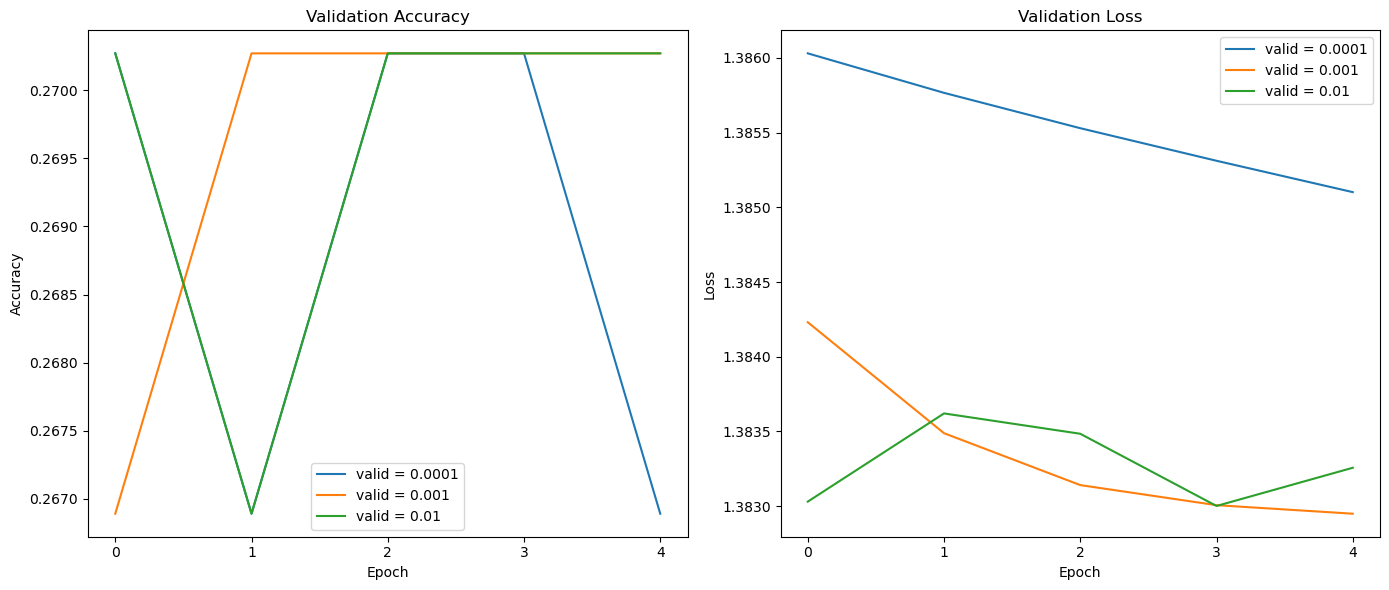

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for lr, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % lr))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for lr, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % lr))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

2. Tuning inner size

In [54]:
learning_rate=0.001
results = {}

for size in [10, 100, 1000]:
    print(size)

    efficientnetb2_model = make_efficientnetb2_model(learning_rate=learning_rate, size_inner=size, droprate=0.0)
    history = efficientnetb2_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[size] = history.history
    
    print()

10
Epoch 1/5


E0000 00:00:1736595427.613762     601 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736595427.798957     601 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 55/149 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7022 - loss: 0.8302

E0000 00:00:1736595446.833960     603 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736595446.982393     603 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7990 - loss: 0.5764

E0000 00:00:1736595473.074214     601 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736595473.234410     601 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 268ms/step - accuracy: 0.7996 - loss: 0.5748 - val_accuracy: 0.9747 - val_loss: 0.1042
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9720 - loss: 0.1105 - val_accuracy: 0.9949 - val_loss: 0.0449
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9909 - loss: 0.0532 - val_accuracy: 0.9983 - val_loss: 0.0253
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9970 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0172
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9971 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.0098

100
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 62s 239ms/step - accuracy: 0.8640 - loss: 0.3744 - val_accuracy: 1.0000 - val_loss: 0.0252
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9964 - loss: 0.0323 - val_accuracy: 0.9966 - val_loss: 0.0128
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9971 - loss: 0.0161 - val_accurac

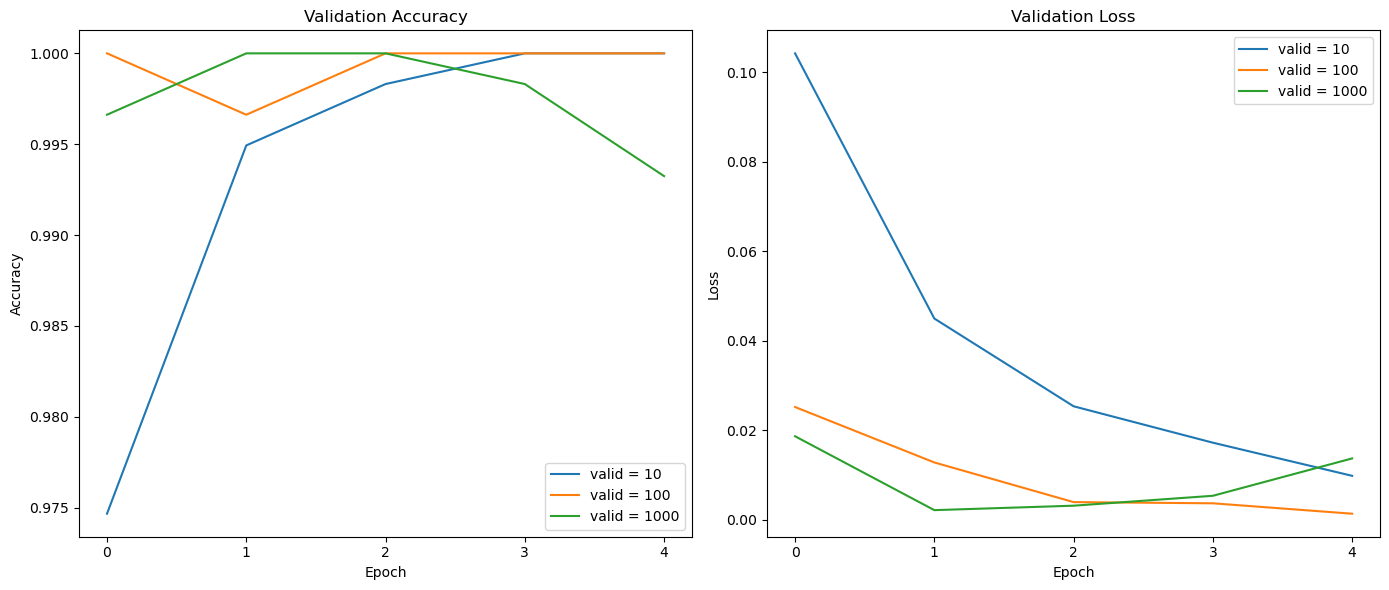

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for size, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % size))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for size, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % size))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

3. Tuning droprate

In [56]:
learning_rate=0.001
size=1000
results = {}

for droprate in [0.0, 0.2, 0.5]:
    print(droprate)

    efficientnetb2_model = make_efficientnetb2_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = efficientnetb2_model.fit(train_dataset, epochs=5, validation_data=valid_dataset)
    results[droprate] = history.history
    
    print()

0.0
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 60s 234ms/step - accuracy: 0.8930 - loss: 0.2752 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9958 - loss: 0.0146 - val_accuracy: 0.9983 - val_loss: 0.0078
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9974 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 8.0363e-04
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9972 - loss: 0.0071 - val_accuracy: 0.9983 - val_loss: 0.0045
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.6920e-04

0.2
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 239ms/step - accuracy: 0.8749 - loss: 0.3020 - val_accuracy: 0.9916 - val_loss: 0.0216
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9943 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9983 - loss

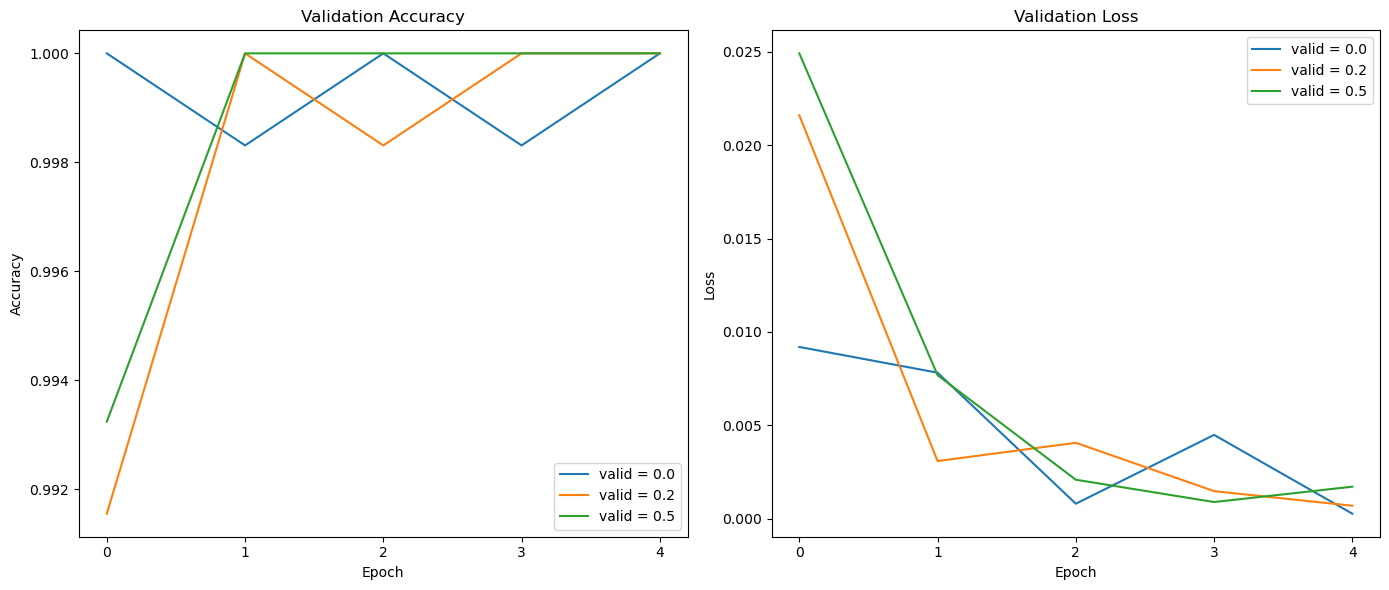

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for droprate, hist in results.items():
    axes[0].plot(hist["val_accuracy"], label=("valid = %s" % droprate))
    axes[0].set_title("Validation Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xticks(np.arange(5))
    axes[0].legend()

for droprate, hist in results.items():
    axes[1].plot(hist["val_loss"], label=("valid = %s" % droprate))
    axes[1].set_title("Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_xticks(np.arange(5))
    axes[1].legend()

plt.tight_layout()
plt.show()

In [58]:
efficientnetb2_checkpoint = ModelCheckpoint("efficientnetb2_{epoch:02d}_{val_accuracy:.3f}.keras", save_best_only=True, monitor="val_accuracy", mode="max")

In [59]:
learning_rate = 0.001
size=1000
droprate=0.0

efficientnetb2_model = make_efficientnetb2_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

history = efficientnetb2_model.fit(train_dataset, epochs=5, validation_data=valid_dataset, callbacks=[efficientnetb2_checkpoint])

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 62s 247ms/step - accuracy: 0.8829 - loss: 0.2977 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9982 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9971 - loss: 0.0080 - val_accuracy: 0.9983 - val_loss: 0.0043
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 6.9629e-04
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9951 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0024


## Summary

For choosing the best model, you can delete previous models whose have lower accuracy than maximum accuracy. <br><br>
If you look at final result of each pre-trained models...

In [60]:
!ls -l

total 618032
-rw-rw-r-- 1 jovyan jovyan       378 Jan 11 01:30 Dockerfile
-rw-r--r-- 1 jovyan jovyan  49234770 Jan 11 11:49 efficientnetb2_01_1.000.keras
-rw-rw-r-- 1 jovyan jovyan       938 Jan 11 01:33 lambda_function.py
-rw-r--r-- 1 jovyan jovyan  25597174 Jan 11 11:31 mobilenet_01_0.998.keras
-rw-r--r-- 1 jovyan jovyan  25597174 Jan 11 11:31 mobilenet_02_1.000.keras
-rw-rw-r-- 1 jovyan jovyan   1757154 Jan 11 11:50 notebook.ipynb
drwxr-sr-x 5 jovyan jovyan      4096 Jan 11 11:12 rice_leaf_datasets
-rw-rw-r-- 1 jovyan jovyan 204845043 Dec 30 08:32 rice_leaf_datasets.zip
-rw-rw-r-- 1 jovyan jovyan       281 Jan 11 01:30 test.py
-rw-rw-r-- 1 jovyan jovyan      4940 Jan 11 10:12 train.py
-rw-r--r-- 1 jovyan jovyan 108594744 Jan 11 11:21 xception_01_0.983.keras
-rw-r--r-- 1 jovyan jovyan 108594744 Jan 11 11:21 xception_03_0.992.keras
-rw-r--r-- 1 jovyan jovyan 108594744 Jan 11 11:21 xception_04_0.998.keras


We see that the best model are from MobileNet and EfficientNetB2 so you can choose one of them for using the model <br>

So why this is happened? Because the dataset which I used is a small dataset so for handling it, MobileNet and EfficientNetB2 are suitable for training a model because those models are lightweight and efficient, therefore they are less prone to overfitting compared to Xception. The heavier the model is, it will prone to overfit

## Using model

For this sub-chapter you should restart your kernel before running those codes below so test dataset can predict an image from a model. In this sublesson, I used EfficientNetB2 as a best model. For more details, you can look to [Keras models documentation website](https://keras.io/api/applications/) <br>

Let's restart our first work by importing libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

Before opening final model, I wanted to rename Keras model

In [4]:
files = glob.glob("efficientnetb2_*.keras")  # Get all files matching the pattern
if files:
    # Extract accuracy and epoch from filenames
    file_with_max_accuracy = max(
        files,
        key=lambda f: float(f.split("_")[2].replace(".keras", ""))
    )
    new_filename = "rice-leaf-disease-prediction-model.keras"
    
    # Rename the file with maximum accuracy
    os.rename(file_with_max_accuracy, new_filename)
    print(f"File renamed to {new_filename}")
else:
    print("No model files found!")

File renamed to rice-leaf-disease-prediction-model.keras


For this code below, you can change the model based on your results that you have gotten previously

In [5]:
final_model = keras.models.load_model(new_filename)

I0000 00:00:1736596531.043398   11280 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


So I prepared the test sets...

In [6]:
test_gen_efficientnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_dataset = test_gen_efficientnet.flow_from_directory("./rice_leaf_datasets/test", target_size=(260,260), batch_size=32, shuffle=False)

Found 595 images belonging to 4 classes.


and then I evaluated from this test dataset...

In [7]:
final_model.evaluate(test_dataset)

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1736596539.436255   11410 service.cc:148] XLA service 0x7f6064003550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736596539.436281   11410 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-11 11:55:39.622374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736596540.374217   11410 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1736596541.337747   11410 gpu_timer.cc:82] Del

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9766 - loss: 0.0423 

I0000 00:00:1736596547.855882   11410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9924 - loss: 0.0215

E0000 00:00:1736596550.647115   11408 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736596550.813003   11408 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 470ms/step - accuracy: 0.9928 - loss: 0.0207


[0.013627439737319946, 0.9966386556625366]

You can see that these are numbers which on the left is loss and on the right is the accuracy. If I opened the image from test set....

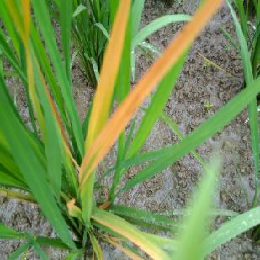

In [8]:
path = "./rice_leaf_datasets/test/Tungro"
name = "TUNGRO1_036.jpg"
img_name = f"{path}/{name}"

img = load_img(img_name, target_size=(260,260))
img

and make an image array...

In [9]:
img_array = np.array(img, dtype="float32")
img = np.array([img_array])
img.shape

(1, 260, 260, 3)

then I preprocessed those image arrays by using Efficien preprocess input and predicted the image...

In [10]:
img = tf.keras.applications.efficientnet.preprocess_input(img)

In [11]:
img

array([[[[ 73., 155.,  11.],
         [ 71., 154.,  10.],
         [ 66., 150.,  10.],
         ...,
         [ 28.,  72.,   0.],
         [ 79., 129.,  40.],
         [ 78., 132.,  34.]],

        [[ 73., 155.,  11.],
         [ 72., 155.,  11.],
         [ 66., 153.,  10.],
         ...,
         [ 28.,  75.,   0.],
         [ 80., 130.,  41.],
         [ 80., 136.,  35.]],

        [[ 73., 157.,  10.],
         [ 72., 157.,  10.],
         [ 66., 156.,   9.],
         ...,
         [ 36.,  85.,   3.],
         [ 81., 134.,  42.],
         [ 80., 138.,  35.]],

        ...,

        [[131., 133., 132.],
         [110., 114., 113.],
         [130., 135., 131.],
         ...,
         [ 81.,  91.,  82.],
         [ 81.,  91.,  82.],
         [ 88.,  95.,  87.]],

        [[131., 135., 134.],
         [118., 122., 121.],
         [132., 137., 133.],
         ...,
         [104., 111., 103.],
         [111., 118., 110.],
         [118., 125., 117.]],

        [[118., 124., 120.],
       

In [12]:
pred = final_model.predict(img)

E0000 00:00:1736596560.626785   11408 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736596560.759675   11408 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [13]:
pred[0]

array([-0.547166 , -1.906996 , -4.9447265,  8.809423 ], dtype=float32)

you will see the prediction like this...

In [14]:
classes = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

dict(zip(classes, pred[0]))

{'Bacterialblight': np.float32(-0.547166),
 'Blast': np.float32(-1.906996),
 'Brownspot': np.float32(-4.9447265),
 'Tungro': np.float32(8.809423)}

So the result of that image above from the test is a tungro disease

## Convert keras model to tf-lite

In [15]:
import tensorflow.lite as tflite

In [16]:
model_converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = model_converter.convert()

with open ("rice-leaf-disease-prediction-model.tflite", "wb") as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg82kf030/assets


INFO:tensorflow:Assets written to: /tmp/tmpg82kf030/assets


Saved artifact at '/tmp/tmpg82kf030'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='input_layer_66')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140053703343184: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140053703340112: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140054960941264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960943760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960939728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960943952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960944720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960939920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960945872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140054960946640: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1736596583.063494   11280 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1736596583.063525   11280 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-11 11:56:23.064021: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg82kf030
2025-01-11 11:56:23.095601: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-11 11:56:23.095639: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpg82kf030
I0000 00:00:1736596583.370427   11280 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-11 11:56:23.419794: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-11 11:56:25.207945: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpg82kf030
2025-01-11 11:56:25.661470: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [17]:
!ls -lh

total 407M
-rw-rw-r-- 1 jovyan jovyan  378 Jan 11 01:30 Dockerfile
-rw-rw-r-- 1 jovyan jovyan  938 Jan 11 01:33 lambda_function.py
-rw-r--r-- 1 jovyan jovyan  25M Jan 11 11:31 mobilenet_02_1.000.keras
-rw-rw-r-- 1 jovyan jovyan 1.4M Jan 11 11:55 notebook.ipynb
drwxr-sr-x 5 jovyan jovyan 4.0K Jan 11 11:12 rice_leaf_datasets
-rw-rw-r-- 1 jovyan jovyan 196M Dec 30 08:32 rice_leaf_datasets.zip
-rw-r--r-- 1 jovyan jovyan  47M Jan 11 11:49 rice-leaf-disease-prediction-model.keras
-rw-r--r-- 1 jovyan jovyan  35M Jan 11 11:56 rice-leaf-disease-prediction-model.tflite
-rw-rw-r-- 1 jovyan jovyan  281 Jan 11 01:30 test.py
-rw-rw-r-- 1 jovyan jovyan 4.9K Jan 11 10:12 train.py
-rw-r--r-- 1 jovyan jovyan 104M Jan 11 11:21 xception_04_0.998.keras


In [18]:
model_interpreter = tflite.Interpreter(model_path="rice-leaf-disease-prediction-model.tflite")
model_interpreter.allocate_tensors()

input_index = model_interpreter.get_input_details()[0]['index']
output_index = model_interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
model_interpreter.set_tensor(input_index, img)
model_interpreter.invoke()
preds = model_interpreter.get_tensor(output_index)

In [20]:
classes = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

dict(zip(classes, preds[0]))

{'Bacterialblight': np.float32(-0.54716253),
 'Blast': np.float32(-1.9069949),
 'Brownspot': np.float32(-4.944731),
 'Tungro': np.float32(8.809425)}

## Removing tf dependency

In [21]:
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [22]:
with Image.open("./rice_leaf_datasets/val/Bacterialblight/BACTERAILBLIGHT5_037.jpg") as img:
    img = img.resize((260, 260), Image.NEAREST)

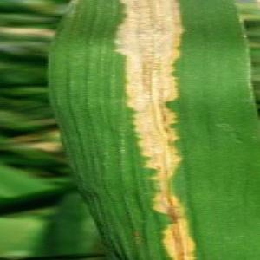

In [23]:
img

In [24]:
img_array = np.array(img, dtype="float32")
img = np.array([img_array])

img = preprocess_input(img)

In [25]:
model_interpreter.set_tensor(input_index, img)
model_interpreter.invoke()
preds = model_interpreter.get_tensor(output_index)

In [26]:
classes = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

dict(zip(classes, preds[0]))

{'Bacterialblight': np.float32(7.822858),
 'Blast': np.float32(1.6703063),
 'Brownspot': np.float32(0.52215326),
 'Tungro': np.float32(-9.049788)}